# Advanced Examples

## Making a Monte Carlo parameter study

In this example we will make a Monte Carlo study. This is case where the python library shows it's advangtage. 

We will make a Monte Carlo study on the position of patella tendon insertion and origin in the simplied knee model used in the first tutorial. Thus, we need some macros that  change two `sRel` variables in the model. In this case we choose the values from a uniform distribution, but any statisctical distribution could have been used. 

In [1]:
from scipy.stats import distributions
import numpy
numpy.random.seed(1)

patella_tendon_insertion = distributions.norm([0.02, 0.12, 0], [0.01,0.01,0.01]) 
patella_tendon_origin = distributions.norm([0.0,-0.03, 0], [0.01,0.01,0.01]) 

In [2]:
from anypytools.generate_macros import MonteCarloMacroGenerator

mg = MonteCarloMacroGenerator(number_of_macros= 100)

mg.add_set_value_random('Main.MyModel.Tibia.Patella2.sRel', patella_tendon_insertion ) 
mg.add_set_value_random('Main.MyModel.Patella.Lig.sRel', patella_tendon_origin ) 

macro_list  = mg.generate_macros()

The first generated macro just have the default values.

In [3]:
macro_list[0]

[u'classoperation Main.MyModel.Tibia.Patella2.sRel "Set Value" --value="{0.02,0.12,0}"',
 u'classoperation Main.MyModel.Patella.Lig.sRel "Set Value" --value="{0,-0.03,0}"']

The next two macros have random offses. 

In [4]:
macro_list[1:4]

[[u'classoperation Main.MyModel.Tibia.Patella2.sRel "Set Value" --value="{0.0179048215908,0.125838057443,-0.0368494766954}"',
  u'classoperation Main.MyModel.Patella.Lig.sRel "Set Value" --value="{-0.00517703515235,-0.0405044888166,-0.0132649077267}"'],
 [u'classoperation Main.MyModel.Tibia.Patella2.sRel "Set Value" --value="{0.0110823783045,0.116026663742,-0.00261723075945}"',
  u'classoperation Main.MyModel.Patella.Lig.sRel "Set Value" --value="{0.000974531575058,-0.032039545338,0.0048234483933}"'],
 [u'classoperation Main.MyModel.Tibia.Patella2.sRel "Set Value" --value="{0.0117417699026,0.131656273938,-0.019206552372}"',
  u'classoperation Main.MyModel.Patella.Lig.sRel "Set Value" --value="{0.00441204466969,-0.0320879329636,0.00147648289627}"']]

Now let us expand the macro to also load and run the model. 

In [5]:
mg = MonteCarloMacroGenerator(number_of_macros= 100)

# Add commands to the macro
mg.add_load('Knee.any')
mg.add_set_value_random('Main.MyModel.Tibia.Patella2.sRel', patella_tendon_insertion ) 
mg.add_set_value_random('Main.MyModel.Patella.Lig.sRel', patella_tendon_origin ) 
mg.add_run_operation('Main.MyStudy.InverseDynamics')
mg.add_dump('Main.MyStudy.Output.MaxMuscleActivity')
mg.add_macro('exit')

macro_list = mg.generate_macros()

The macro is passed to the AnyPyProcess object which excutes the macros

In [6]:
from anypytools.abcutils import AnyPyProcess 

app = AnyPyProcess()
monte_carlo_results = app.start_macro(macro_list)

 [****************100%******************]  100 of 100 complete

The result of the first macro in the Monte Carlo studies is always the default result, i.e. without any random contributions. The remaining elements contain the result of the Monte Carlo study. We can extract this data to calculate the minimum and maximum values.  

In [7]:
import numpy as np
data = np.row_stack((elem['Main.MyStudy.Output.MaxMuscleActivity'] for elem in monte_carlo_results))

Finaly we can plot the result of the Monte Carlo study

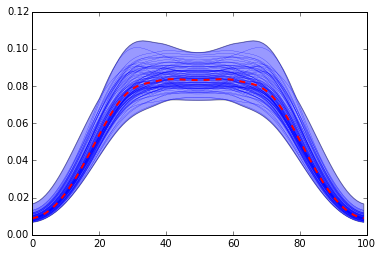

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

x = range(len(data[0]))
plt.fill_between(x, data.min(axis=0), data.max(axis=0),alpha=0.4  )
for trace in data:
    plt.plot( trace,'b', lw=0.2 )

plt.plot(x, data[0],'r--', lw = 2, ) 


## Latin Hypercube sampling

Monte carlo studies are not very efficient when investigating the effect of many parameters. It quickly becomes necessary to run the model tens of thousands of times. Not very convienient if the AnyBody model takes a long time to run. 

An other approach is to use Latin Hypercube sampling. From wikipedia
> Latin hypercube sampling (LHS) is a statistical method for generating a sample of plausible collections of parameter values from a multidimensional distribution. The sampling method is often used to construct computer experiments.

Using LHS we can genrate a sample which better spans the whole multidimensional space. Thus, a lot fever model evaluations are necessary. See [pyDOE](http://pythonhosted.org/pyDOE/randomized.html) for examples (and explanation of the `criterion` parameter).

To following uses LHS to do the same as in the previous example:

In [9]:
from anypytools.generate_macros import LatinHyperCubeMacroGenerator
numpy.random.seed(1)

mg = LatinHyperCubeMacroGenerator(number_of_macros= 18, criterion = 'maximin')
patella_tendon_insertion = distributions.norm([0.02, 0.12, 0], [0.01,0.01,0.01]) 
patella_tendon_origin = distributions.norm([0.0,-0.03, 0], [0.01,0.01,0.01]) 

# Add commands to the macro
mg.add_load('Knee.any')
mg.add_set_value_LHS('Main.MyModel.Tibia.Patella2.sRel', patella_tendon_insertion ) 
mg.add_set_value_LHS('Main.MyModel.Patella.Lig.sRel', patella_tendon_origin ) 
mg.add_run_operation('Main.MyStudy.InverseDynamics')
mg.add_dump('Main.MyStudy.Output.MaxMuscleActivity')
mg.add_macro('exit')

macros = mg.generate_macros()

In [10]:
from anypytools.abcutils import AnyPyProcess 

app = AnyPyProcess()
lhs_results = app.start_macro(macros)

 [****************100%******************]  18 of 18 complete

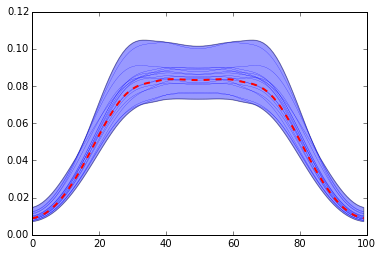

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

data = np.row_stack((elem['Main.MyStudy.Output.MaxMuscleActivity'] for elem in lhs_results))

x = range(len(data[0]))
plt.fill_between(x, data.min(axis=0), data.max(axis=0),alpha=0.4  )
for trace in data:
    plt.plot( trace,'b', lw=0.2 )

plt.plot(x, data[0],'r--', lw = 2, ) 
